In [1]:
# Modules
import numpy as np
import xarray as xr
import pandas as pd

from data import data_loader
from data import gesla_preprocessing
from data import era5_preprocessing
from data import preprocessing

# Description

1. Timelag single predictor data <br>

2. Goal: find most important timelag per predictor <br>

# Working Area

# Modularized Preprocessing

In [2]:
#---
# Modularize Preprocessing
#---

# Get timeseries of predictor and predictand
season = "winter" # ["winter", "autumn",] 
predictors = ["sp", "tp", "u10", "v10",]
percentile = 0.95 # [0.95, 0.99,] 
preprocess = "preprocess1" # ["preprocess1"]
range_of_years = "1999-2008" # ["1999-2008", "2009-2018", "2019-2022",]
subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]
station_names = ["hanko-han-fin-cmems",]

In [3]:
# Load already preprocessed Era5 Data
# Preprocessing done with cdo
#---
predictor = predictors[0]
era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess)

era5_predictor

<xarray.DataArray 'sp' (time: 903, latitude: 121, longitude: 141)>
[15406083 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1999-01-01T11:30:00 ... 2008-12-31T11:30:00
  * longitude  (longitude) float32 -5.0 -4.75 -4.5 -4.25 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 40.5 40.25 40.0
Attributes:
    standard_name:  surface_air_pressure
    long_name:      Surface pressure
    units:          Pa

In [4]:
#---
# Preprocess GESLA Data
#---

# Load Predictand
#---
gesla_predictand = data_loader.load_gesla(station_names)

# Select a season
#---
gesla_predictand = gesla_preprocessing.select_season(gesla_predictand, season)

# Select only sea_level analysis data
#---
gesla_predictand = gesla_preprocessing.get_analysis(gesla_predictand)

# Subtract mean of data grouped by station
#---
gesla_predictand = gesla_predictand["sea_level"] # Detrend expects pd.Series
gesla_predictand = gesla_preprocessing.detrend(gesla_predictand, level="station")

# Apply one hot encoding
gesla_predictand = gesla_preprocessing.apply_dummies(gesla_predictand, percentile=percentile, level="station")
print(f"Applied one-hot-encoding with Percentile: {percentile}")

# Convert to DataArray
# nan values: no measurement at that timestamp for specific station
gesla_predictand = gesla_predictand.to_xarray()

Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95


In [5]:
#---
# Get overlapping time-series
#---
X, Y, t = preprocessing.intersect_time(era5_predictor, gesla_predictand)

print(f"X: {X.shape}")
print(f"Y: {Y.shape}")
print(f"t: {t.shape}")

Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)


In [51]:
#---
# Get timelag of predictor
#---
def timelag(X, Y, t, timelag):
    """
    Description: 
        Returns timelagged predictor data X_timelag for predictors Y_timelag.
    Parameters:
        X (np.array, float): Predictor values as a field time series. Shape:(time, lat, lon)
        Y (np.array, float): Predictand at selected stations. Shape:(time, stations)
        t (np.array, datetime.date): Time-series of intersected timepoints of X and Y. Shape:(time,)
        timelag (int): timelag for predictor data X. Dimension of timelag depends on timeseries-interval of X.
    Returns:
        X_timelag (np.array, float): Predictor values as a field time series (timelagged). Shape:(time, lat, lon)
        Y_timelag (np.array, float): Predictand at selected stations. Shape:(time, stations)
        t_predictor (np.array, datetime.date): Time-series of X (timelagged). Shape:(time,)
        t_predictand (np.array, datetime.date): Time-series of Y. Shape:(time,)

    """
    n_timepoints = len(t)
    # Timelag of predictor 
    # Return predictor data and corresponding timeseries
    #---
    t_predictor = t[:(n_timepoints-timelag)]
    X_timelag =  X[:(n_timepoints-timelag)]

    # Return Predictand data (not lagged) and corresponding timeseries
    #---
    t_predictand = t[timelag:]
    Y_timelag = Y[timelag:]

    return (X_timelag, Y_timelag, t_predictor, t_predictand)

In [7]:
#---
# Timelag predictor
#---
from data import preprocessing
timelags = [1, 2, 3, 5, 7,]
for timelag_ in timelags[:1]:
    X_timelag, Y_timelag, t_predictor, t_predictand = preprocessing.timelag(X, Y, t, timelag_)

## One Timelag, one Model

Starting run for sp and timelag = 1
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (902, 17061)
y.shape : (902,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_0951.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.9292035398230089
train_score: 1.0
importance: [1.21635025e-04 1.39310529e-04 5.63317793e-05 ... 1.81469139e-04
 2.16981390e-04 2.98521086e-04]
Created directory: results/random_forest/rf005/
saved importance to : results/random_forest/rf005/importance_95_0
Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : results/random_forest/rf005/cf_matrix_95_0.jpg
Metric values 

tnr: 0.9804878048780488
tpr: 0.42857142857142855
gmean: 0.6482353424748217
wacc: 0.7045296167247387
precision: 0.6923076923076923
recall: 0.42857142857142855
fmeasure: 0.5294117647058824
saved cf metrics to : cf_metrics_95_0.pkl
Show AUROC 

AUC: 0.910801393728223
saved AUROC to : results/random_forest/rf005/AUROC_95_0.jpg
Ended run for sp and timelag = 1
Starting run for sp and timelag = 2
Load Predictand from GESLA


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (901, 17061)
y.shape : (901,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_195.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8893805309734514
train_score: 1.0
importance: [0.00000000e+00 3.20029776e-05 0.00000000e+00 ... 3.18277658e-04
 9.96216752e-04 6.80979272e-04]
saved importance to : results/random_forest/rf005/importance_95_1
Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()
d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved cf matrix to : results/random_forest/rf005/cf_matrix_95_1.jpg
Metric values 

tnr: 0.96875
tpr: 0.4411764705882353
gmean: 0.653750492070448
wacc: 0.7049632352941176
precision: 0.7142857142857143
recall: 0.4411764705882353
fmeasure: 0.5454545454545455
saved cf metrics to : cf_metrics_95_1.pkl
Show AUROC 

AUC: 0.9068627450980392
saved AUROC to : results/random_forest/rf005/AUROC_95_1.jpg
Ended run for sp and timelag = 2
Starting run for sp and timelag = 3
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (900, 17061)
y.shape : (900,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV

d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_295.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.88
train_score: 0.9896296296296296
importance: [0.00000000e+00 2.62418018e-04 6.53584801e-07 ... 4.95440136e-04
 1.14055984e-04 2.26005174e-04]
saved importance to : results/random_forest/rf005/importance_95_2
Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 

saved cf matrix to : results/random_forest/rf005/cf_matrix_95_2.jpg

d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()



Metric values 

tnr: 0.8994974874371859
tpr: 0.7307692307692307
gmean: 0.8107558738444811
wacc: 0.8151333591032084
precision: 0.48717948717948717
recall: 0.7307692307692307
fmeasure: 0.5846153846153846
saved cf metrics to : cf_metrics_95_2.pkl
Show AUROC 

AUC: 0.914572864321608


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved AUROC to : results/random_forest/rf005/AUROC_95_2.jpg
Ended run for sp and timelag = 3
Starting run for sp and timelag = 5
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (898, 17061)
y.shape : (898,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_395.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8711111111111111
train_score: 1.0
importance: [2.02969524e-04 5.78739017e-04 9.16130492e-05 ... 1.04901044e-04
 0.00000000e+00 1.49581607e-05]
saved importance to : results/random_forest/rf005/importance_95_3
Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()
d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved cf matrix to : results/random_forest/rf005/cf_matrix_95_3.jpg
Metric values 

tnr: 0.9481865284974094
tpr: 0.40625
gmean: 0.6206454520916693
wacc: 0.6772182642487047
precision: 0.5652173913043478
recall: 0.40625
fmeasure: 0.4727272727272727
saved cf metrics to : cf_metrics_95_3.pkl
Show AUROC 

AUC: 0.9158031088082901
saved AUROC to : results/random_forest/rf005/AUROC_95_3.jpg
Ended run for sp and timelag = 5
Starting run for sp and timelag = 7
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (896, 17061)
y.shape : (896,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3

d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_495.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8660714285714286
train_score: 1.0
importance: [1.87271075e-05 1.37768754e-04 4.86237687e-05 ... 1.76455374e-04
 2.20032812e-04 7.15885383e-04]
saved importance to : results/random_forest/rf005/importance_95_4
Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : results/random_forest/rf005/cf_matrix_95_4.jpg
Metric values 

tnr: 0.9790575916230366
tpr: 0.21212121212121213
gmean: 0.455717986337552
wacc: 0.5955894018721244
precision: 0.6363636363636364
recall: 0.21212121212121213
fmeasure: 0.3181818181818182
saved cf metrics to : cf_metrics_95_4.pkl
Show AUROC 

AUC: 0.838886244645407
saved AUROC to : results/random_forest/rf005/AUROC_95_4.jpg
Ended run for sp and timelag = 7
Starting run for tp and timelag = 1


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (902, 17061)
y.shape : (902,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_595.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.9203539823008849
train_score: 0.9985207100591716
importance: [3.76859780e-05 0.00000000e+00 0.00000000e+00 ... 1.53736979e-04
 9.41406029e-05 2.44218928e-04]
saved importance to : results/random_forest/rf005/importance_95_5
Load ERA5-Predictor: tp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : results/random_forest/rf005/cf_matrix_95_5.jpg
Metric values 

tnr: 0.9951219512195122
tpr: 0.19047619047619047
gmean: 0.4353700016394402
wacc: 0.5927990708478513
precision: 0.8
recall: 0.19047619047619047
fmeasure: 0.3076923076923077
saved cf metrics to : cf_metrics_95_5.pkl
Show AUROC 

AUC: 0.8657375145180023


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved AUROC to : results/random_forest/rf005/AUROC_95_5.jpg
Ended run for tp and timelag = 1
Starting run for tp and timelag = 2
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (901, 17061)
y.shape : (901,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_695.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8495575221238938
train_score: 0.9985185185185185
importance: [0.         0.         0.         ... 0.00077385 0.         0.        ]
saved importance to : results/random_forest/rf005/importance_95_6
Load ERA5-Predictor: tp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 

saved cf matrix to : results/random_forest/rf005/cf_matrix_95_6.jpg
Metric values 

tnr: 0.984375
tpr: 0.08823529411764706
gmean: 0.29471446799751594
wacc: 0.5363051470588235
precision: 0.5
recall: 0.08823529411764706
fmeasure: 0.15


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()
d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:257: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(tight_layout=True)
d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved cf metrics to : cf_metrics_95_6.pkl
Show AUROC 

AUC: 0.8916973039215685
saved AUROC to : results/random_forest/rf005/AUROC_95_6.jpg
Ended run for tp and timelag = 2
Starting run for tp and timelag = 3
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (900, 17061)
y.shape : (900,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_795.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.88
train_score: 1.0
importance: [0.         0.         0.         ... 0.         0.00051629 0.        ]
saved importance to : results/random_forest/rf005/importance_95_7
Load ERA5-Predictor: tp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 

saved cf matrix to : results/random_forest/rf005/cf_matrix_95_7.jpg
Metric values 

tnr: 0.9899497487437185
tpr: 0.038461538461538464
gmean: 0.19512813824842604
wacc: 0.5142056436026285
precision: 0.3333333333333333
recall: 0.038461538461538464
fmeasure: 0.06896551724137931
saved cf metrics to : cf_metrics_95_7.pkl
Show AUROC 

AUC: 0.8932160804020102


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()
d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved AUROC to : results/random_forest/rf005/AUROC_95_7.jpg
Ended run for tp and timelag = 3
Starting run for tp and timelag = 5
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (898, 17061)
y.shape : (898,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_895.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8622222222222222
train_score: 0.9717682020802377
importance: [0.         0.         0.00015792 ... 0.         0.         0.        ]
saved importance to : results/random_forest/rf005/importance_95_8
Load ERA5-Predictor: tp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 

saved cf matrix to : results/random_forest/rf005/cf_matrix_95_8.jpg
Metric values 

tnr: 0.9481865284974094
tpr: 0.34375
gmean: 0.5709107803947868
wacc: 0.6459682642487047
precision: 0.5238095238095238
recall: 0.34375
fmeasure: 0.4150943396226415
saved cf metrics to : cf_metrics_95_8.pkl
Show AUROC 

AUC: 0.9010686528497409


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()
d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved AUROC to : results/random_forest/rf005/AUROC_95_8.jpg
Ended run for tp and timelag = 5
Starting run for tp and timelag = 7
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (896, 17061)
y.shape : (896,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_995.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8526785714285714
train_score: 1.0
importance: [0.00000000e+00 2.75149537e-05 3.03119045e-05 ... 7.49399480e-05
 6.40388385e-05 4.36349232e-05]
saved importance to : results/random_forest/rf005/importance_95_9
Load ERA5-Predictor: tp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : results/random_forest/rf005/cf_matrix_95_9.jpg
Metric values 

tnr: 0.9947643979057592
tpr: 0.030303030303030304
gmean: 0.17362135725225142
wacc: 0.5125337141043947
precision: 0.5
recall: 0.030303030303030304
fmeasure: 0.05714285714285715
saved cf metrics to : cf_metrics_95_9.pkl
Show AUROC 

AUC: 0.8037442487704267
saved AUROC to : results/random_forest/rf005/AUROC_95_9.jpg
Ended run for tp and timelag = 7
Starting run for u10 and timelag = 1


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (902, 17061)
y.shape : (902,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_1095.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.9026548672566371
train_score: 1.0
importance: [3.98457599e-05 3.24282143e-19 2.97210573e-06 ... 1.14070587e-04
 1.03097884e-04 0.00000000e+00]
saved importance to : results/random_forest/rf005/importance_95_10
Load ERA5-Predictor: u10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : results/random_forest/rf005/cf_matrix_95_10.jpg
Metric values 

tnr: 0.9560975609756097
tpr: 0.38095238095238093
gmean: 0.6035127523726592
wacc: 0.6685249709639953
precision: 0.47058823529411764
recall: 0.38095238095238093
fmeasure: 0.42105263157894735
saved cf metrics to : cf_metrics_95_10.pkl
Show AUROC 

AUC: 0.8727061556329848


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved AUROC to : results/random_forest/rf005/AUROC_95_10.jpg
Ended run for u10 and timelag = 1
Starting run for u10 and timelag = 2
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (901, 17061)
y.shape : (901,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_1195.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8716814159292036
train_score: 0.9925925925925926
importance: [0.00000000e+00 5.29677088e-06 0.00000000e+00 ... 3.25245138e-07
 0.00000000e+00 2.96741840e-05]
saved importance to : results/random_forest/rf005/importance_95_11
Load ERA5-Predictor: u10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : results/random_forest/rf005/cf_matrix_95_11.jpg
Metric values 

tnr: 0.9739583333333334
tpr: 0.29411764705882354
gmean: 0.5352180241110471
wacc: 0.6340379901960784
precision: 0.6666666666666666
recall: 0.29411764705882354
fmeasure: 0.40816326530612246
saved cf metrics to : cf_metrics_95_11.pkl
Show AUROC 

AUC: 0.883578431372549
saved AUROC to : results/random_forest/rf005/AUROC_95_11.jpg
Ended run for u10 and timelag = 2
Starting run for u10 and timelag = 3
Load Predictand from GESLA


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (900, 17061)
y.shape : (900,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_1295.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8933333333333333
train_score: 0.957037037037037
importance: [6.90058502e-05 1.21679364e-04 0.00000000e+00 ... 0.00000000e+00
 1.23160787e-05 1.17618720e-04]
saved importance to : results/random_forest/rf005/importance_95_12
Load ERA5-Predictor: u10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : results/random_forest/rf005/cf_matrix_95_12.jpg
Metric values 

tnr: 0.9095477386934674
tpr: 0.7692307692307693
gmean: 0.8364520946756501
wacc: 0.8393892539621184
precision: 0.5263157894736842
recall: 0.7692307692307693
fmeasure: 0.625
saved cf metrics to : cf_metrics_95_12.pkl
Show AUROC 

AUC: 0.9493621955933514


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved AUROC to : results/random_forest/rf005/AUROC_95_12.jpg
Ended run for u10 and timelag = 3
Starting run for u10 and timelag = 5
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (898, 17061)
y.shape : (898,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_1395.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8755555555555555
train_score: 0.9955423476968797
importance: [0.00000000e+00 6.53383076e-05 2.83098652e-05 ... 0.00000000e+00
 1.11755945e-04 1.80028598e-04]
saved importance to : results/random_forest/rf005/importance_95_13
Load ERA5-Predictor: u10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : results/random_forest/rf005/cf_matrix_95_13.jpg
Metric values 

tnr: 0.9792746113989638
tpr: 0.25
gmean: 0.4947915246341038
wacc: 0.6146373056994818
precision: 0.6666666666666666
recall: 0.25
fmeasure: 0.36363636363636365
saved cf metrics to : cf_metrics_95_13.pkl
Show AUROC 

AUC: 0.9399287564766841


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved AUROC to : results/random_forest/rf005/AUROC_95_13.jpg
Ended run for u10 and timelag = 5
Starting run for u10 and timelag = 7
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (896, 17061)
y.shape : (896,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_1495.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8705357142857143
train_score: 0.9464285714285714
importance: [0.         0.00032473 0.         ... 0.         0.         0.00011523]
saved importance to : results/random_forest/rf005/importance_95_14
Load ERA5-Predictor: u10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 

saved cf matrix to : results/random_forest/rf005/cf_matrix_95_14.jpg


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


Metric values 

tnr: 0.93717277486911
tpr: 0.48484848484848486
gmean: 0.6740821907872497
wacc: 0.7110106298587975
precision: 0.5714285714285714
recall: 0.48484848484848486
fmeasure: 0.5245901639344263
saved cf metrics to : cf_metrics_95_14.pkl
Show AUROC 

AUC: 0.8553069966682533
saved AUROC to : results/random_forest/rf005/AUROC_95_14.jpg


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Ended run for u10 and timelag = 7
Starting run for v10 and timelag = 1
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (902, 17061)
y.shape : (902,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_1595.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8805309734513275
train_score: 0.9467455621301775
importance: [0.0011367  0.00118794 0.00093106 ... 0.         0.         0.00019672]
saved importance to : results/random_forest/rf005/importance_95_15
Load ERA5-Predictor: v10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : results/random_forest/rf005/cf_matrix_95_15.jpg
Metric values 

tnr: 0.9170731707317074
tpr: 0.5238095238095238
gmean: 0.6930884942483649
wacc: 0.7204413472706156
precision: 0.39285714285714285
recall: 0.5238095238095238
fmeasure: 0.4489795918367347
saved cf metrics to : cf_metrics_95_15.pkl
Show AUROC 

AUC: 0.8301974448315912


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


saved AUROC to : results/random_forest/rf005/AUROC_95_15.jpg
Ended run for v10 and timelag = 1
Starting run for v10 and timelag = 2
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (901, 17061)
y.shape : (901,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_1695.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8672566371681416
train_score: 0.997037037037037
importance: [0.00131823 0.         0.         ... 0.         0.00026579 0.        ]
saved importance to : results/random_forest/rf005/importance_95_16
Load ERA5-Predictor: v10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : results/random_forest/rf005/cf_matrix_95_16.jpg
Metric values 

tnr: 0.9895833333333334
tpr: 0.17647058823529413
gmean: 0.41789035995243595
wacc: 0.5830269607843137
precision: 0.75
recall: 0.17647058823529413
fmeasure: 0.2857142857142857
saved cf metrics to : cf_metrics_95_16.pkl
Show AUROC 

AUC: 0.8198529411764706
saved AUROC to : results/random_forest/rf005/AUROC_95_16.jpg


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Ended run for v10 and timelag = 2
Starting run for v10 and timelag = 3
Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (900, 17061)
y.shape : (900,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_1795.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8977777777777778
train_score: 0.9733333333333334
importance: [1.21241481e-03 9.72128808e-04 7.58582790e-04 ... 5.87084514e-05
 5.03580259e-05 8.30882115e-05]
saved importance to : results/random_forest/rf005/importance_95_17
Load ERA5-Predictor: v10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : results/random_forest/rf005/cf_matrix_95_17.jpg
Metric values 

tnr: 0.9396984924623115
tpr: 0.5769230769230769
gmean: 0.7362973215022133
wacc: 0.7583107846926942
precision: 0.5555555555555556
recall: 0.5769230769230769
fmeasure: 0.5660377358490566
saved cf metrics to : cf_metrics_95_17.pkl
Show AUROC 

AUC: 0.8658678005411674
saved AUROC to : results/random_forest/rf005/AUROC_95_17.jpg
Ended run for v10 and timelag = 3
Starting run for v10 and timelag = 5
Load Predictand from GESLA


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (898, 17061)
y.shape : (898,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_1895.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8222222222222222
train_score: 0.9569093610698366
importance: [5.59521277e-05 0.00000000e+00 1.00068094e-06 ... 0.00000000e+00
 3.09652192e-04 4.07967254e-05]
saved importance to : results/random_forest/rf005/importance_95_18
Load ERA5-Predictor: v10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 



d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()


saved cf matrix to : results/random_forest/rf005/cf_matrix_95_18.jpg
Metric values 

tnr: 0.9222797927461139
tpr: 0.21875
gmean: 0.44916445169137376
wacc: 0.570514896373057
precision: 0.3181818181818182
recall: 0.21875
fmeasure: 0.25925925925925924
saved cf metrics to : cf_metrics_95_18.pkl
Show AUROC 

AUC: 0.8424546632124352
saved AUROC to : results/random_forest/rf005/AUROC_95_18.jpg
Ended run for v10 and timelag = 5
Starting run for v10 and timelag = 7
Load Predictand from GESLA


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Applied one-hot-encoding with Percentile: 0.95
Get overlapping timeseries of ERA5 and GESLA
X: (903, 121, 141)
Y: (903, 1)
t: (903,)
Data is prepared as follows
X.shape : (896, 17061)
y.shape : (896,)
Start Model Training
Do Train-Test-Split
Optimize Hyperparameters
Tested Hyperparameters: {'n_estimators': [0, 111, 222, 333, 444, 555, 666, 777, 888, 1000], 'max_depth': [5, 17, 30, 42, 55, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Optimize Hyperparameters using RandomSearchCV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_forest.py", line 392, in fit
    self._validate_estimator()
  File "d:\Programme\miniconda3\envs\mlpy38\lib\site-packages\sklearn\ensemble\_base.py", line 138, in _validate_estimator
    raise ValueError(
Va

File saved to: models/random_forest/rf005/rf005_1995.pkl
Saved Hyperparameters
Fit model
Save model
Evaluate Model 

test_score: 0.8660714285714286
train_score: 1.0
importance: [1.95245719e-03 0.00000000e+00 3.87067146e-04 ... 1.39731254e-04
 3.47193241e-04 1.28281276e-05]
saved importance to : results/random_forest/rf005/importance_95_19
Load ERA5-Predictor: v10 in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Show Confusion Matrix 

saved cf matrix to : results/random_forest/rf005/cf_matrix_95_19.jpg


d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:225: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig.show()
d:\OneDrive\Alle_Ordner\Coding\Python\master_thesis\models\random_forest\rf005.py:264: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Metric values 

tnr: 0.9895287958115183
tpr: 0.15151515151515152
gmean: 0.3872061536520147
wacc: 0.5705219736633349
precision: 0.7142857142857143
recall: 0.15151515151515152
fmeasure: 0.25
saved cf metrics to : cf_metrics_95_19.pkl
Show AUROC 

AUC: 0.7848643503093765
saved AUROC to : results/random_forest/rf005/AUROC_95_19.jpg
Ended run for v10 and timelag = 7


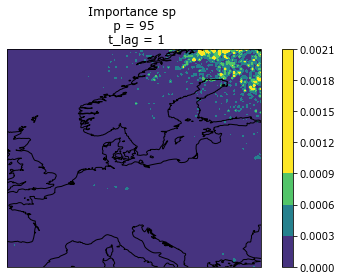

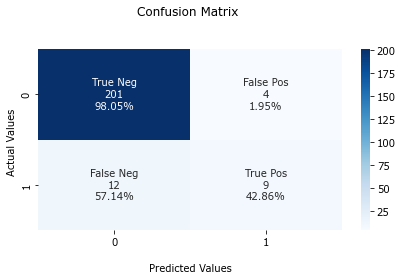

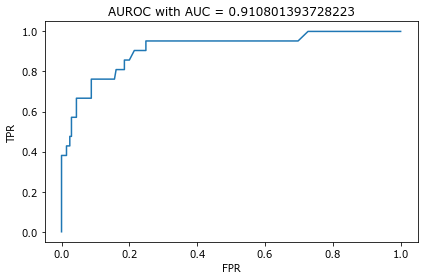

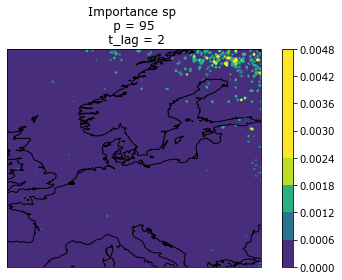

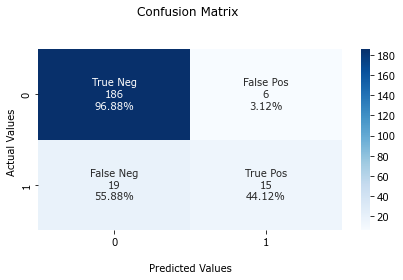

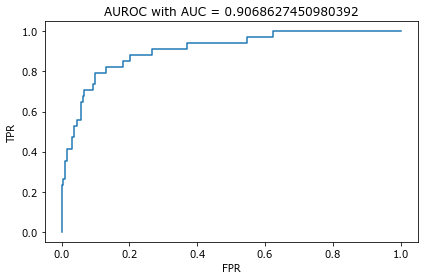

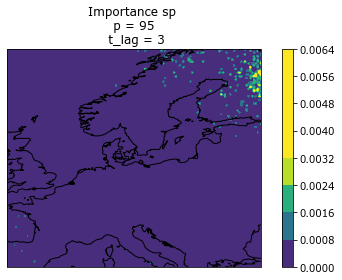

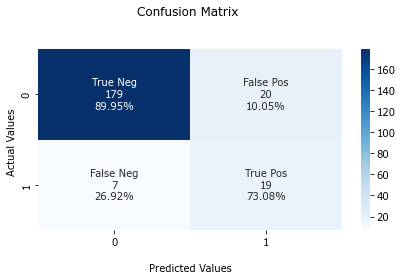

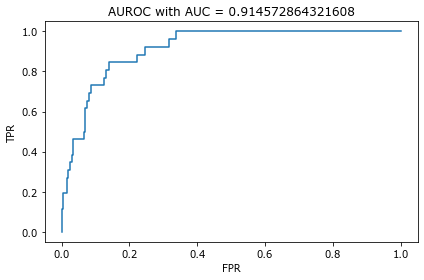

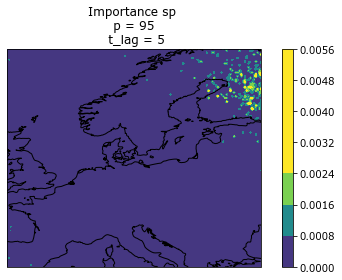

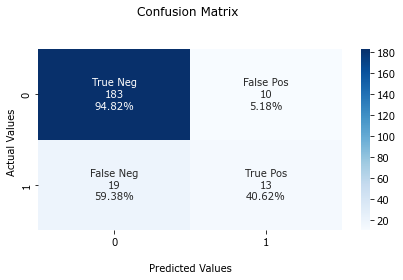

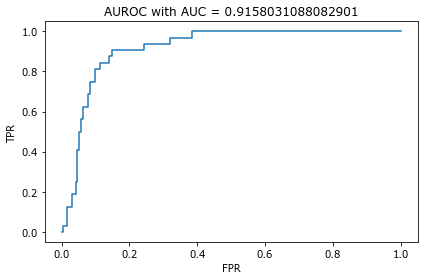

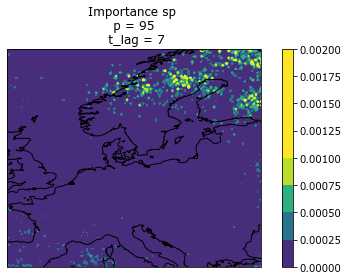

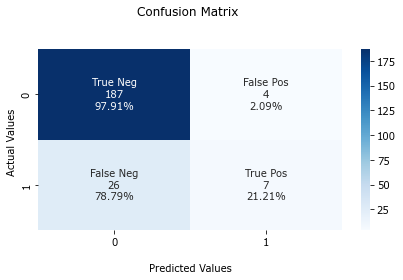

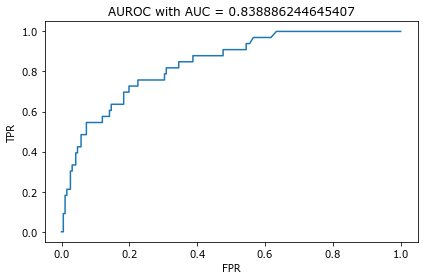

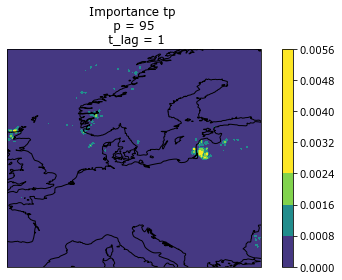

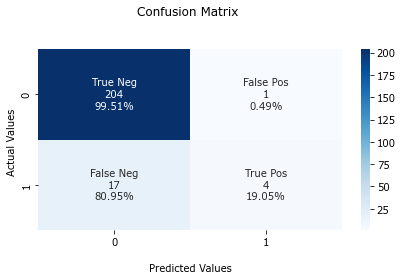

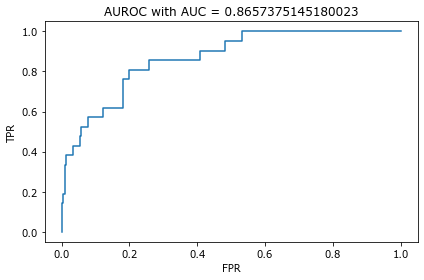

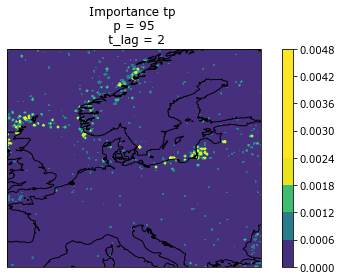

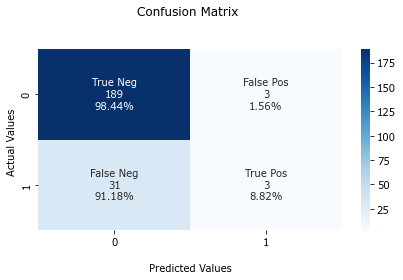

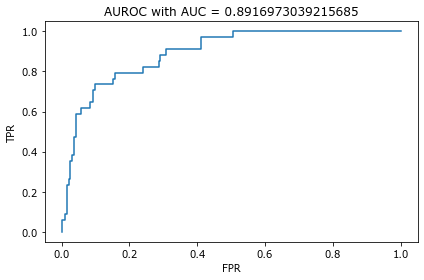

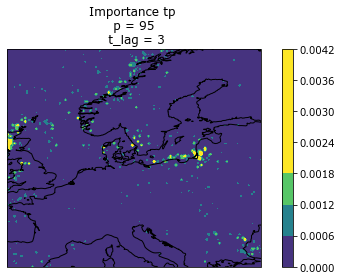

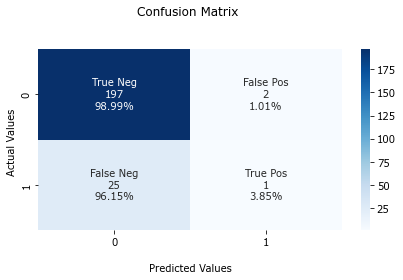

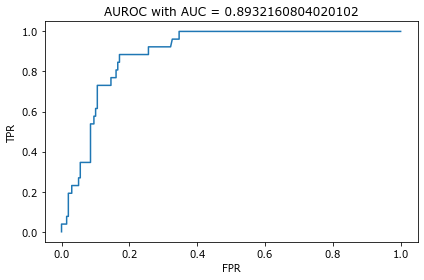

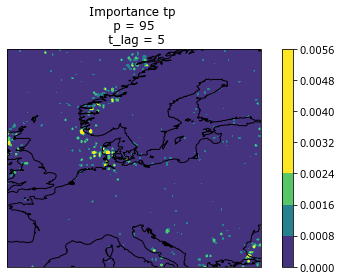

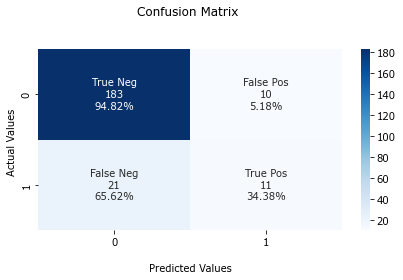

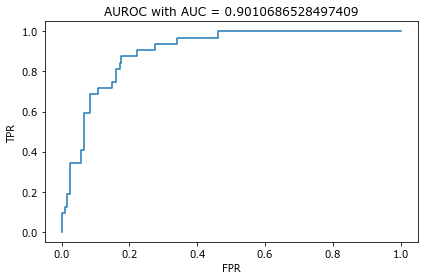

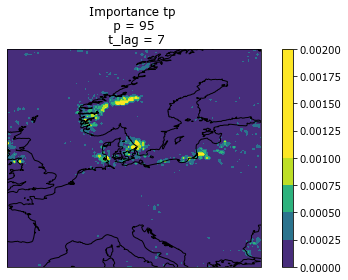

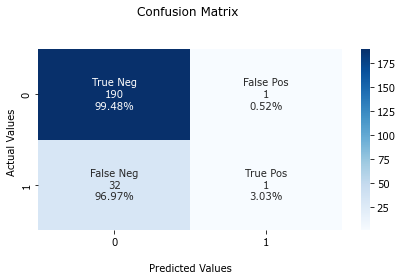

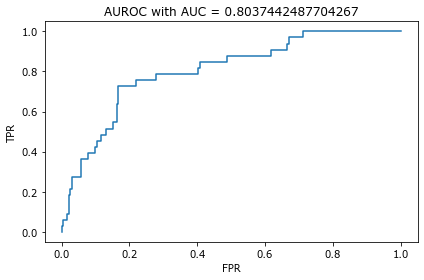

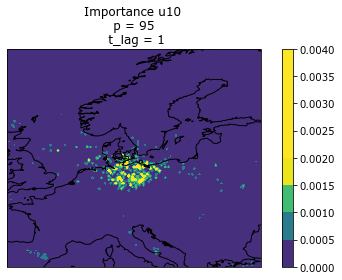

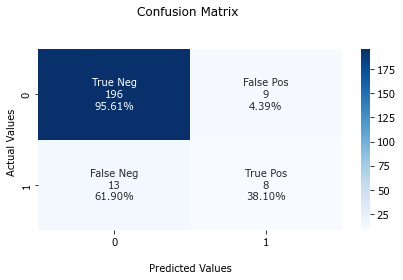

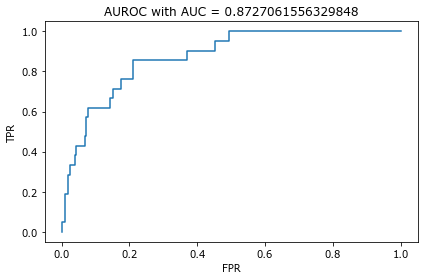

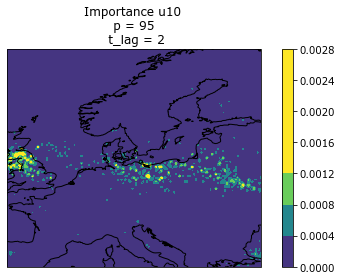

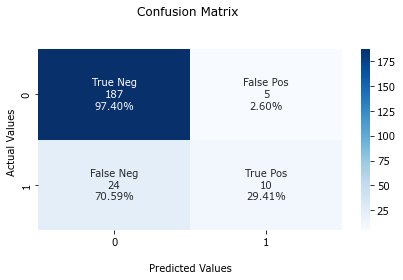

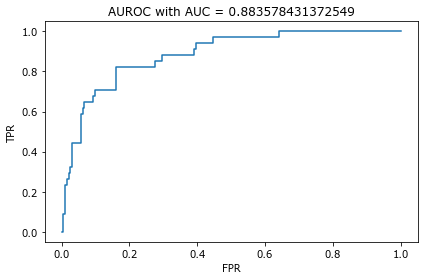

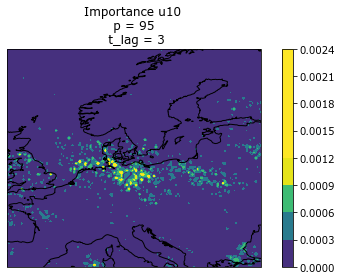

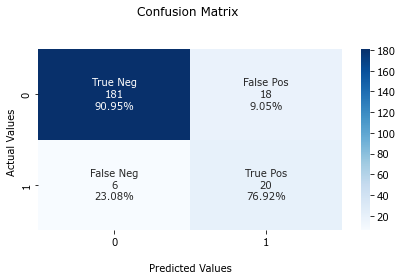

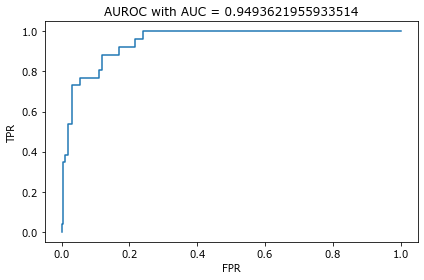

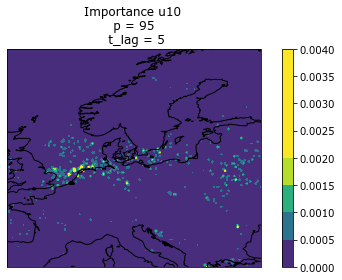

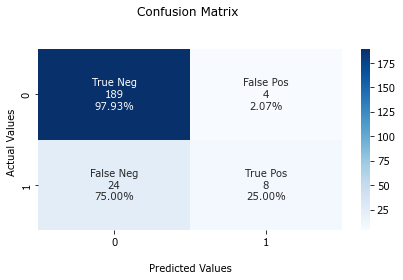

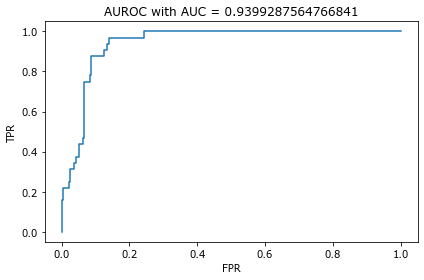

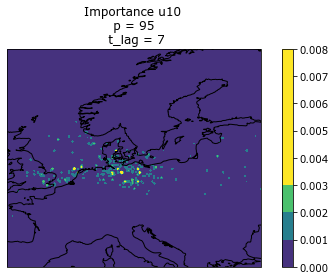

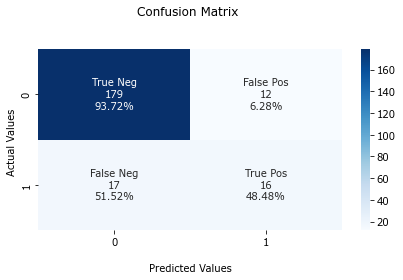

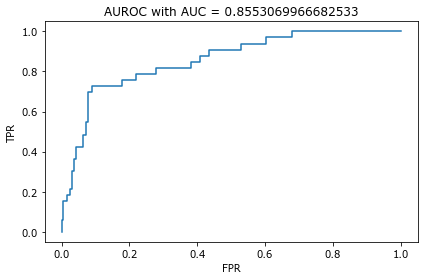

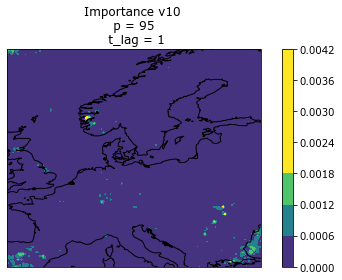

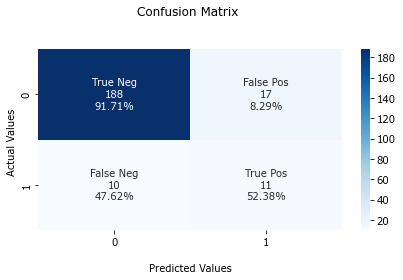

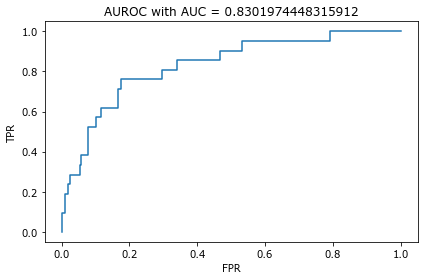

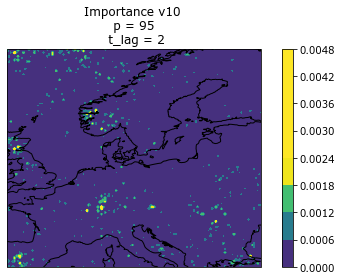

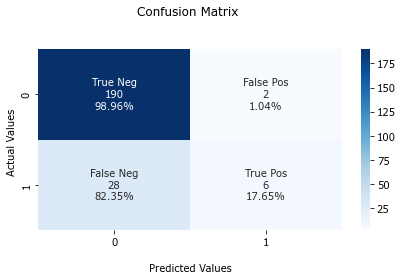

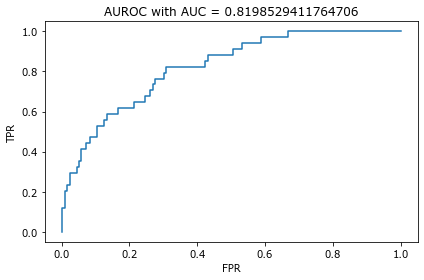

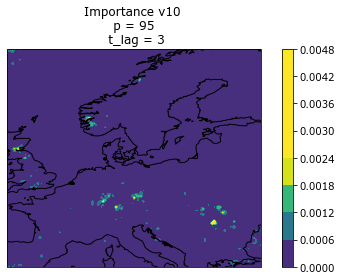

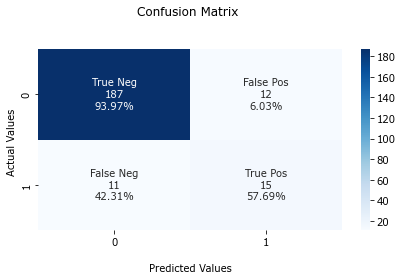

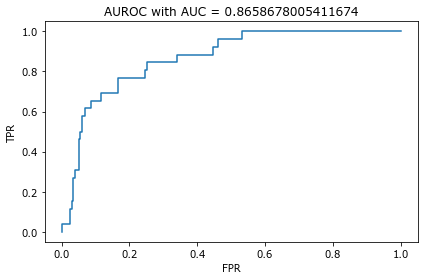

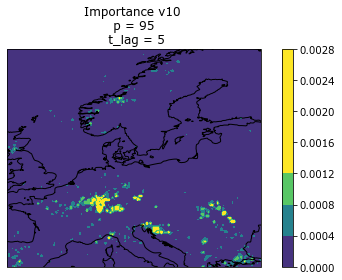

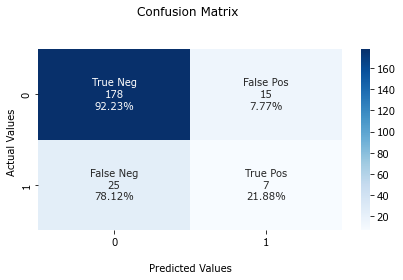

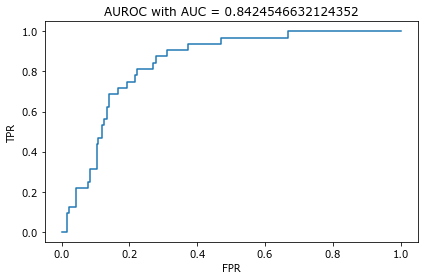

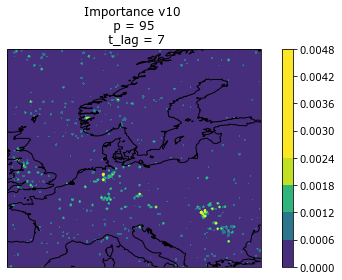

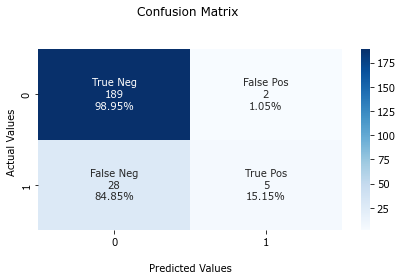

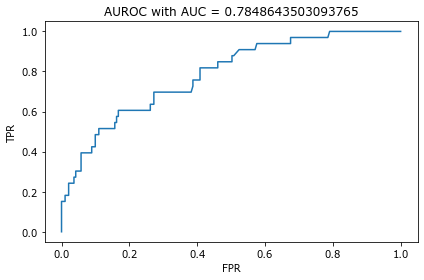

In [2]:
#---
# Main
#---
from models.random_forest.rf005 import run

season = "winter" # ["winter", "autumn",] 
percentile = 0.95 # [0.95, 0.99,] 
station_names = ["hanko-han-fin-cmems",]
predictors = ["sp", "tp", "u10", "v10",]
timelags = [1, 2, 3, 5, 7,]
model_run = "rf005"

run_id = 0
for predictor in predictors:
    for timelag_ in timelags:
        print(f"Starting run for {predictor} and timelag = {timelag_}")
        run(season, predictor, timelag_, percentile, station_names, run_id, model_run)
        print(f"Ended run for {predictor} and timelag = {timelag_}")
        
        run_id = run_id + 1